# Case study: Out-of-distribution generalization

## Task b2: Image regression (Figure 5)

In [1]:
import sys
sys.path = ['../'] + sys.path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from datetime import datetime

### Auxiliary functions

#### Plotting

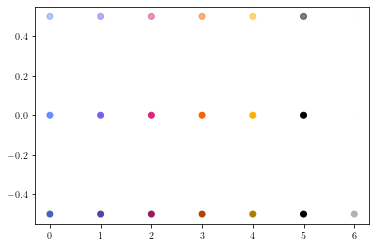

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
color_blind_1 = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4', '#020202',]
color_blind_2 = ['#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac']
color_blind_3 = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]
rainbow10 = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#7395ff", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]


# Pick one and show

palette = ibm_color_blind

base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

#### Custom PyTorch dataset for the images

In [5]:
class TorchImageDataset(torch.utils.data.Dataset):
    """
    To load the image datasets.
    """
    
    def __init__(self,images,labels,mean_labels=None,std_labels=None):
        
        # Normalize labels
        self.mean_labels = labels.mean(axis=0, keepdims=True) if mean_labels is None else mean_labels        
        self.std_labels = labels.std(axis=0, keepdims=True) if std_labels is None else std_labels        
        self.n = len(labels)
        self.labels = torch.tensor((labels - self.mean_labels) / self.std_labels, dtype=torch.float32)    

        # Process images: tensors with pixel values between [-1,1]        
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.images = [torch.unsqueeze(transform(im), 0) for im in images]
        self.images = torch.cat(self.images) # Concatenate images into a single tensor

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.images[idx], self.labels[idx]

### Download dataset

In [6]:
import causalchamber.datasets as datasets
camera_dataset = datasets.Dataset(name="lt_color_regression_v1", root="/tmp")
camera_dataset.available_experiments()


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:TODO},
  year={2024}
}

Dataset lt_color_regression_v1 found in "/tmp/lt_color_regression_v1".


['iso_1000.0',
 'aperture_5.0',
 'aperture_11.0',
 'shutter_speed_0.002',
 'reference',
 'bright_colors',
 'pol_1_90',
 'iso_500.0',
 'shutter_speed_0.001',
 'pol_1_45']

### Split into train / test / validation sets and standardize

We will use the experiments data as follows:

- training set: `reference`
- validation sets: experiments
    - `bright_colors`
    - `iso_1000.0`
    - `apreture_11.0`
    - `shutter_speed_0.001`
    - `regression_pol_1_90`

In [7]:
experiments = [
    'reference',
    'bright_colors',    
    'iso_1000.0',
    'aperture_11.0',
    'shutter_speed_0.001',
    'pol_1_90',
]
images_labels = {}
size = '100'
responses = ['red', 'green', 'blue']
print("Loading")
for name in experiments:
    print("  ", name)
    experiment = camera_dataset.get_experiment(name)    
    labels = experiment.as_pandas_dataframe()[responses]
    images = experiment.as_image_array(size)
    images_labels[name] = (images,labels)

Loading
   reference
   bright_colors
   iso_1000.0
   aperture_11.0
   shutter_speed_0.001
   pol_1_90


In [9]:
n_validate = 500
n_test = 500
Ns = [9000]
datasets = {}

for n in Ns:
    print("n =",n)
    (all_images,df) = images_labels['reference']
    
    df_train = df.sample(n=n, random_state=1)[responses]
    images_train = all_images[df_train.index]
    df_rest = df.drop(df_train.index)
    
    df_test = df_rest.sample(n=n_test, random_state=2)[responses]
    images_test = all_images[df_test.index]
    df_rest = df_rest.drop(df_test.index)
    
    df_validate = df_rest.sample(n=n_validate, random_state=3)[responses]
    images_validate = all_images[df_validate.index]
    
    # Cast into torch dataset and normalize
    dataset_train = TorchImageDataset(images_train, df_train.values)
    standardization = {'mean_labels': dataset_train.mean_labels,
                       'std_labels': dataset_train.std_labels}    
    # Training dataset
    datasets[n] = {}
    print('  train')
    datasets[n]['train'] = dataset_train    
    # Test dataset
    print('  test')
    datasets[n]['test'] = TorchImageDataset(images_test, df_test.values, **standardization)
    # Validate dataset (training dist.)
    print('  validate')
    datasets[n]['validate'] = TorchImageDataset(images_validate, df_validate.values, **standardization)
    
    # Other validation datasets (distribution shifts)    
    for name, (images, labels) in images_labels.items():
        if name == 'reference':
            continue
        print(" ",name)
        labels = labels.sample(n=n_validate, random_state=len(name))
        images = images[labels.index]
        datasets[n][name] = TorchImageDataset(images, labels.values, **standardization)

n = 9000
  train
  test
  validate
  bright_colors
  iso_1000.0
  aperture_11.0
  shutter_speed_0.001
  pol_1_90


### Train or load models for each sample size

In [10]:
train = False

In [11]:
from torch.utils.data import DataLoader
import time
def train_model(model, dataset_train, dataset_test, epochs=300, batch_size=2048,learning_rate=1e-3, weight_decay=1e-5, device="cuda",every=15):    
    print("Device: %s" % device, " batch size:", batch_size)    

    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam
    opt_args = {'lr': learning_rate, 'weight_decay': weight_decay}    

    # Dataloaders
    dataloader_args = {'shuffle': True, 'num_workers':0}
    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, **dataloader_args)
    X_test, Y_test = next(iter(DataLoader(dataset_test, batch_size=len(dataset_test))))

    # Initiate optimizer
    optimizer = optimizer(model.parameters(), **opt_args)

    # Training loop
    for epoch in range(epochs):
        start = time.time()
        print(f"\nEpoch {epoch}") if epoch % every == 0 else None
        for i,(X,Y) in enumerate(train_dataloader):            

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(X)
            loss = loss_function(y_pred, Y.to(device))

            # Zero gradients, backward pass, and update weights

            loss.backward()
            optimizer.step()

            # Compute test loss        
            y_pred_test = model(X_test)
            test_loss = loss_function(y_pred_test, Y_test.to(device)).item()
        elapsed = time.time() - start
        # Print progress every 100 epochs
        if epoch % every == 0:
            print(f"Epoch {epoch}, {elapsed:0.1f} seconds , Loss: {loss.item()}, Test loss: {test_loss}")
            
    return model

In [12]:
torch.cuda.empty_cache()    

In [15]:
from src.models import CNNLinearHead as CNN
fitted_models = dict((n,[]) for n in Ns)
seeds = np.arange(16) # TODO: change back to 16
for seed in seeds:
    print("-"*50)
    print("seed:",seed)
    torch.manual_seed(seed)    
    torch.cuda.empty_cache()    
    for n in Ns:        
        print("\n\n\nn =", len(datasets[n]['train']))
        path = f"torch_models/cnn_n_{n}_seed_{seed}.pkl"
        model = CNN(len(responses), device="cuda")
        if train:            
            model = train_model(model, datasets[n]['train'], datasets[n]['test'], batch_size=2048)
            torch.save(model.state_dict(), path)
            print(f'Saved model to "{path}"')
        else:            
            model.load(path)
        fitted_models[n].append(model)

--------------------------------------------------
seed: 0



n = 9000
--------------------------------------------------
seed: 1



n = 9000
--------------------------------------------------
seed: 2



n = 9000
--------------------------------------------------
seed: 3



n = 9000
--------------------------------------------------
seed: 4



n = 9000
--------------------------------------------------
seed: 5



n = 9000
--------------------------------------------------
seed: 6



n = 9000
--------------------------------------------------
seed: 7



n = 9000
--------------------------------------------------
seed: 8



n = 9000
--------------------------------------------------
seed: 9



n = 9000
--------------------------------------------------
seed: 10



n = 9000
--------------------------------------------------
seed: 11



n = 9000
--------------------------------------------------
seed: 12



n = 9000
--------------------------------------------------
seed: 13



n = 9000
--

### Compute MAE

In [35]:
def denormalize(x,n):
    means = datasets[n]['train'].mean_labels[0][0]
    stds = datasets[n]['train'].std_labels[0][0]
    return stds * x + means
    

In [36]:
MAEs = np.zeros((len(Ns), len(datasets[Ns[0]]), len(seeds)))
dataset_names = datasets[Ns[0]].keys()
indices = dict(zip(dataset_names, np.arange(len(dataset_names))))
with torch.no_grad():    
    for i,n in enumerate(Ns):        
        for key,dataset in datasets[n].items():
            for k,model in enumerate(fitted_models[n]):
                impulses, truths = next(iter(DataLoader(dataset, batch_size=len(dataset))))
                truths = denormalize(truths.numpy(), n)            
                pred = model(impulses).detach().cpu().numpy()
                pred = denormalize(pred,n)            
                mae = (abs(pred - truths)).sum() / len(dataset)            
                MAEs[i,indices[key],k] = mae

In [37]:
MAEs_mean = np.zeros((len(Ns), len(datasets[Ns[0]]), len(seeds)))
# Compute mean of training dataset
mean = df_train.mean().values
for i,n in enumerate(Ns):            
    print(mean)
    for key,dataset in datasets[n].items():
        for k,model in enumerate(fitted_models[n]):
            impulses, truths = next(iter(DataLoader(dataset, batch_size=len(dataset))))
            truths = denormalize(truths.numpy(), n)            
            pred = mean            
            mae = (abs(pred - truths)).sum() / len(dataset)            
            MAEs_mean[i,indices[key],k] = mae

[63.16       63.71511111 62.895     ]


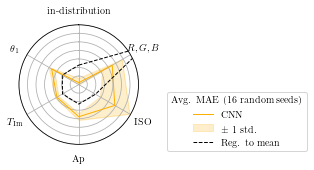

In [48]:
# Taken from https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
mmax = 300

plt.figure(figsize=(2.2,2.2))

def t(x):
    return x
    return np.power(x, 1/3)
    
# ------- PART 1: Create background
 
# number of variables

labels = {'validate': 'in-distribution',
          'pol_1_90': r'$\theta_1$',
          'iso_1000.0': r'$\text{ISO}$',
          'aperture_11.0': r'$\text{Ap}$',
          'bright_colors': r'$R,G,B$',
          'shutter_speed_0.001': r'$T_\text{Im}$',
         }
categories=[name for _,name in enumerate(dataset_names) if name not in ['test', 'train']]
categories = [labels[c] for c in categories]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
yticks = np.linspace(0,mmax,8)
plt.yticks(t(yticks), [])
plt.ylim(0,t(mmax))
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data

# CNN
j = 0
n = Ns[j]
mean = t(MAEs[j,2:,:].mean(axis=1))
mean = np.array(list(mean) + [mean[0]])
std = t(MAEs[j,2:,:].std(axis=1))
std = np.array(list(std) + [std[0]])
i=4
ax.plot(angles, mean, linewidth=1, linestyle='solid', color = base[i], label = "CNN")
ax.plot(angles, mean+std, linewidth=0.1, linestyle='-', color = base[i])
ax.plot(angles, mean-std, linewidth=0.1, linestyle='-', color = base[i])
#ax.fill(angles, values, color=base[i]*np.array([1,1,1,0.2]))
ax.fill_between(angles, mean+std, np.maximum(0,mean-std), color=base[i]*np.array([1,1,1,0.2]),label = "$\quad \pm$ 1 std.")

# Reg. to the mean
mean = t(MAEs_mean[j,2:,:].mean(axis=1))
mean = np.array(list(mean) + [mean[0]])
std = t(MAEs_mean[j,2:,:].std(axis=1))
std = np.array(list(std) + [std[0]])
i=5
ax.plot(angles, mean, linewidth=1, linestyle='--', color = base[i], label = "Reg. to mean")
#ax.fill(angles, values, color=base[i]*np.array([1,1,1,0.2]))
#ax.fill_between(angles, mean+std, np.maximum(0,mean-std), color=base[i]*np.array([1,1,1,0.2]),label = "$\pm$ 1 std.")

legend = plt.legend(loc='lower left', bbox_to_anchor=(1.2, -0.1), title="Avg. MAE (16 random seeds)")

# Show the graph
plt.savefig(f"../figures/image_regression_n_{n}.pdf", bbox_inches="tight", transparent="True")

#### By hand on the validation dataset

In [46]:
n = 9000
#iterator = iter(DataLoader(datasets[n]['lt_color_regression_iso_1000.0'], batch_size=1))
#iterator = iter(DataLoader(datasets[n]['bright_colors'], batch_size=1))
#iterator = iter(DataLoader(datasets[n]['pol_1_90'], batch_size=1))
iterator = iter(DataLoader(datasets[n]['iso_1000.0'], batch_size=1))
#iterator = iter(DataLoader(datasets[n]['validate'], batch_size=1))
i = 0

In [47]:
model = fitted_models[n][0]

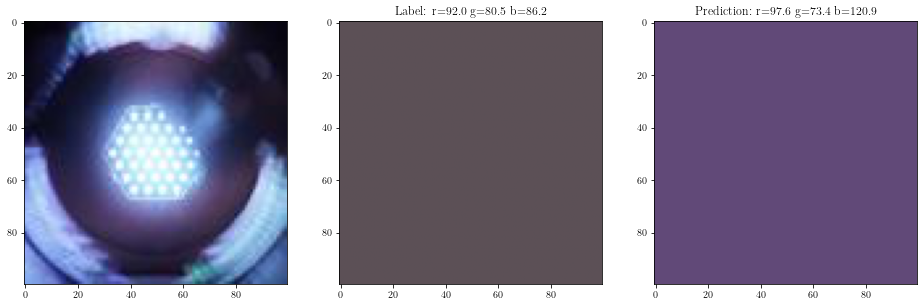

In [62]:
with torch.no_grad():
    image, Y = next(iterator)    
    
    obs = denormalize(Y.numpy()[0],n)
    obs = pd.Series(obs, index=['red', 'green', 'blue'])    
    
    pred = model(image).detach().cpu()    
    pred = denormalize(pred.numpy()[0],n)
    pred = pd.Series(pred, index=['red', 'green', 'blue'])

    image = image.numpy()[0]
    image = np.transpose(image, (1,2,0))
    plt.figure(figsize=(16,8))

    plt.subplot(131)
    plt.imshow((image+1)/2)

    plt.subplot(132)
    color = np.ones_like(image, dtype=float)
    color[:,:,0] *= obs.red/255
    color[:,:,1] *= obs.green/255
    color[:,:,2] *= obs.blue/255
    plt.imshow(color)
    plt.title(f"Label: r={obs.red:0.1f} g={obs.green:0.1f} b={obs.blue:0.1f}")

    plt.subplot(133)
    color = np.ones_like(image, dtype=float)
    color[:,:,0] *= pred.red/255
    color[:,:,1] *= pred.green/255
    color[:,:,2] *= pred.blue/255
    plt.imshow(color)
    plt.title(f"Prediction: r={pred.red:0.1f} g={pred.green:0.1f} b={pred.blue:0.1f}")

    i += 1